# Plucker vectors and coordinate transforms

Here we discuss the use of Plücker vectors and their transforms for
describing rigid-body motion and force. Plücker vectors succinctly describe
both the angular (rotational) and linear (translational) part of motion, and the angular (moment) and
linear (force) part of force. In three dimensions, a Plücker vector is 6-dimensional,
e.g., Plücker velocity and force vectors are

$$v = \begin{bmatrix} \Omega_x \\ \Omega_y \\ \Omega_z \\ U_x \\ U_y \\ U_z \end{bmatrix}, \qquad
f = \begin{bmatrix} M_x \\ M_y \\ M_z \\ F_x \\ F_y \\ F_z \end{bmatrix}$$

In two dimensions, there is only one angular component and two linear components, e.g.,

$$v = \begin{bmatrix} \Omega_z \\ U_x \\ U_y \end{bmatrix}, \qquad f = \begin{bmatrix} M_z \\ F_x \\ F_y \end{bmatrix}$$

We need to be able to transform these vectors from one coordinate system to another.
This requires rotating their components and shifting their center from one origin to another.
For example, a translational velocity based at system B will be different from
the translational velocity at system A because of the rotational velocity, $\Omega \times {}^Br_{A}$,
where ${}^Br_{A}$ is the vector from the origin of A to the origin of B.

Similarly, the moment about B will be different from the moment about A due to
the moment arm ${}^Br_{A} \times F$.

In [1]:
using RigidBodyTools
using LinearAlgebra
using Plots

## Plücker vectors
A Plücker vector is easily created by simply supplying a vector of its components

In [2]:
v = PluckerMotion([1.0,2.0,3.0])

2d Plucker motion vector, Ω = 1.0, U = [2.0, 3.0]

This created a 2d motion vector, with angular velocity 1.0 and linear
velocity (2.0,3.0). One can also supply the angular and linear
parts separately, using keywords. If one of these keywords is
omitted, it defaults to zero for that part. Note that we also need
to write this as `PluckerMotion{2}` to specify the physical dimensionality.
For a 3d motion vector, one would write `PluckerMotion{3}` here.

In [3]:
v2 = PluckerMotion{2}(angular=1.0,linear=[2.0,3.0])
v2 == v

true

We can also pick off the angular and linear parts

In [4]:
angular_only(v)

2d Plucker motion vector, Ω = 1.0, U = [0.0, 0.0]

and

In [5]:
linear_only(v)

2d Plucker motion vector, Ω = 0.0, U = [2.0, 3.0]

Force vectors are similar

In [6]:
f = PluckerForce([-1.0,-3.5,2.25])

2d Plucker force vector, M = -1.0, F = [-3.5, 2.25]

The vectors of the same type can be added and subtracted

In [7]:
v3 = v + v2

2d Plucker motion vector, Ω = 2.0, U = [4.0, 6.0]

We can also take a scalar product of force and motion vectors

In [8]:
dot(f,v)

-1.25

## Transforms
Transforms are constructed by describing the relationship between the two
coordinate systems. Consider the example in the figure below.

![CoordinateSystems.svg](CoordinateSystems.svg)

To develop the 2d transform from A to B, we supply the position $r$ and
the rotation angle $\theta$. For example, if B is shifted by [1,1]
and rotated by angle $\pi/6$ counterclockwise about A, then we construct the transform
as

In [9]:
Xm = MotionTransform([1,1],π/6)

2d motion transform, x = [1.0, 1.0], R = [0.8660254037844387 0.49999999999999994; -0.49999999999999994 0.8660254037844387]

Note that it uses the angle of rotation, $\pi/6$, to create a rotation
matrix operator.

A 2d force transform would be constructed by

In [10]:
Xf = ForceTransform([1,1],π/6)

2d force transform, x = [1.0, 1.0], R = [0.8660254037844387 0.49999999999999994; -0.49999999999999994 0.8660254037844387]

For 3d transforms, we need to supply the rotation operator itself (as well
as the 3d translation vector). Often, this rotation is done by
rotating about a certain axis by a certain angle. We do this with the
`rotation_about_axis` function. For example, to rotate by $\pi/4$ about
an axis parallel to the vector $[1,1,1]$, then we use

In [11]:
R = rotation_about_axis(π/4,[1,1,1])

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.804738  -0.310617   0.505879
  0.505879   0.804738  -0.310617
 -0.310617   0.505879   0.804738

and then to translate this rotated system by $[-1,-2,-3]$,

In [12]:
Xm = MotionTransform([-1,-2,-3],R)

3d motion transform, x = [-1, -2, -3], R = [0.8047378541243648 -0.31061721752604554 0.5058793634016806; 0.5058793634016806 0.8047378541243648 -0.31061721752604554; -0.31061721752604554 0.5058793634016806 0.8047378541243648]

and similarly for a force transform.

We can also compute the inverses of these transforms, to transform back from
B to A

In [13]:
inv(Xm)

3d motion transform, x = [1.7011415092773154, 1.1835034190722733, 3.11535507165041], R = [0.8047378541243648 0.5058793634016806 -0.31061721752604554; -0.31061721752604554 0.8047378541243648 0.5058793634016806; 0.5058793634016806 -0.31061721752604554 0.8047378541243648]

Transforms of the same type (motion or force) can be composed via multiplication to transform
from, e.g., A to B to C.

In [14]:
Xm1 = MotionTransform([1.5,1.5],π/6)
Xm2 = MotionTransform([-1,1],π/3)
Xm2*Xm1

2d motion transform, x = [0.1339745962155614, 1.8660254037844388], R = [2.220446049250313e-16 1.0; -1.0 2.220446049250313e-16]

## Transforming bodies
We can use motion transforms, in particular, to place bodies. We simply
apply the transform as a function, and it transforms the body's
coordinates. For example, transform `Xm1` above shifts the
body to `[1.5,1.5]` and rotates it counterclockwise by `π/6`:

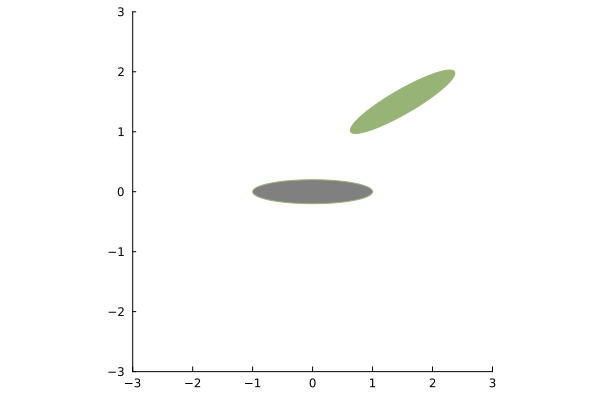

In [15]:
b = Ellipse(1.0,0.2,0.02)
plot(b,xlims=(-3,3),ylims=(-3,3),fillcolor=:gray)
plot!(Xm1(b),xlims=(-3,3),ylims=(-3,3))

In the example above, we did not affect the original body by applying the
transform as a function. Rather, we created a copy of the body.

If, instead, you wish to transform the body in place, use `update_body!`

In [16]:
update_body!(b,Xm1)

Elliptical body with 208 points and semi-axes (1.0,0.2)
   Current position: (1.5,1.5)
   Current angle (rad): 0.5235987755982987


One important note: a body stores a set of coordinates in its own intrinsic
coordinate system, and when a transform is applied to the body, it always
acts on these coordinates. This means that the transform's application on the body
cannot be carried out as a composite of operations, e.g. `T2(T1(b))` is not possible.
Insteady, in the application on the body, the transform is always interpreted such that system A
is the inertial coordinate system and B is the body system. Of course, the transform itself can always
be constructed from composite transforms.

Sometimes we need information about the normals in the body system.
For these, we can use `normalmid` with the flag `ref=true`:

In [17]:
nx, ny = normalmid(b,ref=true)

([0.9999999999999883, 0.8863353378017462, 0.7369383257079377, 0.6074921092236701, 0.5315356836790982, 0.4600208693807857, 0.4196286225913724, 0.3738367953815684, 0.3490372105916199, 0.31621751783169716  …  0.2993769584369277, 0.3162178254216863, 0.3490368976184099, 0.3738371031048394, 0.41962831573128584, 0.4600211639931911, 0.5315354051225935, 0.6074923550501512, 0.7369381416992703, 0.8863354243292069], [-0.0, 0.46304391688467517, 0.6759599870574864, 0.7943257123063382, 0.8470359006416437, 0.8879081032033344, 0.9076958847004161, 0.9274945015572188, 0.9371088654059198, 0.9486867140507255  …  -0.954134915385159, -0.9486866115243656, -0.937108981976452, -0.9274943775259099, -0.9076960265620415, -0.8879079505660332, -0.8470360754425764, -0.7943255243007183, -0.6759601876655256, -0.4630437512580992])

## Transforming Plücker vectors
Transforms can be applied to Plücker vectors to transform their components
between systems. Let's consider a 2d example in which the motion based at system A
is purely a rotation with angular velocity $\Omega = 1$, and we wish to transform this
to system B, translated by $[2,0]$ from A, but with axes aligned with B.
We expect that the velocity based at B should have the same angular velocity,
but also should have translational velocity equal to $[0,2]$ due to the angular
motion.

First we construct the motion vector at A

In [18]:
Ω = 1.0
vA = PluckerMotion(Ω,[0,0])

2d Plucker motion vector, Ω = 1.0, U = [0.0, 0.0]

Now construct the transform from A to B:

In [19]:
XA_to_B = MotionTransform([2,0],0)

2d motion transform, x = [2.0, 0.0], R = [1.0 -0.0; 0.0 1.0]

Now apply the transform to get the velocity at B:

In [20]:
vB = XA_to_B*vA

2d Plucker motion vector, Ω = 1.0, U = [0.0, 2.0]

which gives the expected result. Now let's transform back, using the inverse,
and check that we get back to `vA`

In [21]:
inv(XA_to_B)*vB

2d Plucker motion vector, Ω = 1.0, U = [0.0, 0.0]

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*